In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3")

In [4]:
env.observation_space.n, env.action_space.n

(500, 6)

### $\varepsilon$-Greedy Policy:
$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [1]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    prob = np.ones(action_n) * epsilon / action_n
    argmax_action = np.argmax(q_values)
    prob[argmax_action] += 1 - epsilon
    action = np.random.choice(np.arange(action_n), p=prob)
    return action

### Monte-Carlo Algorithm

Пусть $Q(s,a) = 0$, $N(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k \in \overline{1,K}$ делаем:

1. Согласно $\pi = \varepsilon\text{-greedy}(Q)$ получаем траекторию $\tau = (S_0,A_0,\ldots,S_T)$ и награды $(R_0,\ldots,R_{T-1})$. По ним определяем $(G_0,\ldots,G_{T-1}):$
$$
G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_t,\quad G_{T-1} = R_{T-1},\quad G_{T-2} = R_{T-2} + \gamma R_{T-1},\quad G_i = R_i + \gamma G_{i+1},\quad G_{T} = Q(S_T,\pi_{greedy}(S_T)).
$$

2. Для каждого $t \in \overline{0,T-1}$ обновляем $Q$ и $N$:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big),
$$

$$
N(S_t,A_t) \leftarrow N(S_t,A_t) + 1
$$
Уменьшаем $\varepsilon$


In [13]:
def MonteCarlo(env, episode_n, trajectory_len=500, gamma=0.99):
    state_n = env.observation_space.n 
    action_n = env.action_space.n

    q_values = np.zeros((state_n, action_n))
    counters = np.zeros((state_n, action_n))

    total_rewards = []
    for episode in range(episode_n):
        epsilon = 1 - episode / episode_n

        trajectory = {'states': [], 'actions': [], 'rewards': []}

        state, _ = env.reset()
        for t in range(trajectory_len):
            action = get_epsilon_greedy_action(q_values[state], epsilon, action_n)
            next_state, reward, done, _, _ = env.step(action)

            trajectory['states'].append(state)
            trajectory['actions'].append(action)
            trajectory['rewards'].append(reward)

            state = next_state

            if done:
                break

        total_rewards.append(np.sum(trajectory['rewards']))

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            counters[state][action] += 1
            q_values[state][action] += (returns[t] - q_values[state][action]) / counters[state][action]

    return total_rewards

### Solving Taxi-v2 by means of MonteCarlo

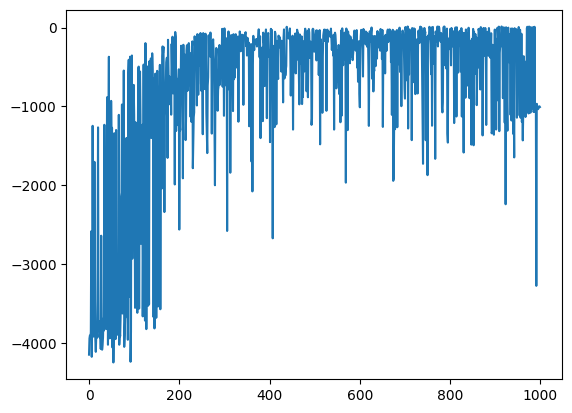

In [15]:
total_rewards = MonteCarlo(env, episode_n=1000, trajectory_len=1000, gamma=0.99)

plt.plot(total_rewards)
plt.show()

### SARSA Algorithm 
Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$, переходим в состояние $S_{t+1}$, совершаем действие $A_{t+1} \sim \pi(\cdot|S_{t+1})$

2. По $(S_t,A_t,R_t,S_{t+1},A_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$


In [19]:
def SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    state_n = env.observation_space.n 
    action_n = env.action_space.n

    q_values = np.zeros((state_n, action_n))

    total_rewards = []
    for episode in range(episode_n):
        epsilon = 1 - episode / episode_n

        total_reward = 0

        state, _ = env.reset()
        action = get_epsilon_greedy_action(q_values[state], epsilon, action_n)
        for t in range(trajectory_len):
            next_state, reward, done, _, _ = env.step(action)
            next_action = get_epsilon_greedy_action(q_values[next_state], epsilon, action_n)

            q_values[state][action] += alpha * (reward + gamma * q_values[next_state][next_action] - q_values[state][action])

            total_reward += reward

            state = next_state
            action = next_action

            if done:
                break

        total_rewards.append(total_reward)
    
    return total_rewards

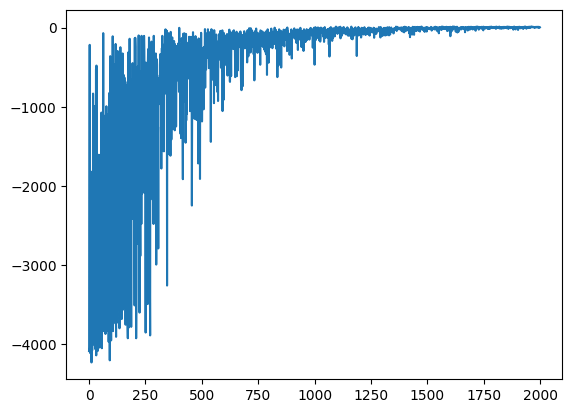

In [20]:
total_rewards = SARSA(env, episode_n=2000, trajectory_len=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

### Q-Learning Algorithm

Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$.

2. По $(S_t,A_t,R_t,S_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q(S_{t+1},a') - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$

In [2]:
def QLearning(env, episode_n, noisy_episode_n, gamma=0.99, t_max=500, alpha=0.5):
    pass

In [21]:
total_rewards = QLearning(env, episode_n=500, noisy_episode_n=400, t_max=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

NameError: name 'QLearning' is not defined